# Unfolding with RooUnfold 4: Bias, Variance and Coverage

Now armed with a more powerful example and a strong understanding of the various components of the unfolding toolbox we can start to get into the big questions:
- **Which Unfolding Algorithm?**
- **Which Regulariation Strength?**

Now there is no hard and fast advice for these questions. It depends on your analysis, your data, and your preference. However, there are a few tools which we can use to guide this decision.

In [1]:
import ROOT
import numpy as np

In file included from input_line_33:1:
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/dlfcn.h:64:37: warning: unknown platform 'driverkit' in availability macro [-Wavailability]
extern int dlclose(void * __handle) __DYLDDL_DRIVERKIT_UNAVAILABLE;
                                    ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/dlfcn.h:44:41: note: expanded from macro '__DYLDDL_DRIVERKIT_UNAVAILABLE'
 #define __DYLDDL_DRIVERKIT_UNAVAILABLE __API_UNAVAILABLE(driverkit)
                                        ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/Availability.h:419:190: note: expanded from macro '__API_UNAVAILABLE'
    #define __API_UNAVAILABLE(...) __API_UNAVAILABLE_GET_MACRO(__VA_ARGS__,__API_UNAVAILABLE7,__API_UNAVAILABLE6,__API_UNAVAILABLE5,__API_UNAVAILABLE4,__API_UNAVAILABLE3,__API_UNAVAILABLE2,__API_UNAVAILABLE1, 0)(__VA_ARGS__)
                                                                                           

Welcome to JupyROOT 6.26/04


### Regularised Methods

Regularised unfolding thus requires a choice of algorithm by, for example, selecting a regularisation function $S( \vec{\mu})$ , as well as some prescription for setting the degree of regularisation, e.g., through the parameter $\tau$ or the number of iterations used in the Lucy- Richardson algorithm. The regularisation parameter determines the trade-off between bias and statistical variance in the estimators $\hat{\vec{\mu}}$ that result. 

### Mean Squared Error - aka $\mathrm{bias}^2+\mathrm{variance}$
A quantity that represents this trade-off is the mean squared error (sum of bias squared and variance) averaged over the bins,

$$
\mathrm{MSE} = \frac{1}{M}\sum_{i=1}^{M}(V[\hat{\mu}_i]+b_i^2)
$$

Where the bias $b_i$ are a property of the estimators defined as the difference between estimator’s expectation and parameter’s true values,

$$
b_i = E[\hat{\mu}_i]-\mu_i
$$

and the variances $V[\hat{\mu}_i]$ (also written $\sigma^2_\hat{\mu_i}$) defined as the diagonal elements of the covariance matrix $\mathrm{cov}[\hat{\mu_i},\hat{\mu_j}]$.

Minimising the (bin-averaged) MSE as defined above is one of the criteria demonstrated here for setting the regularisation parameter.

### Coverage Probability
Another criterion that can be employed to set the degree of regularisation is based on the coverage probability of confidence intervals constructed for each bin of the true histogram. These can be taken as extending between plus and minus one standard deviation about the estimator, i.e., $[\hat{\mu}_i - \sigma_{\hat{\mu_i}} , \hat{\mu}_i + \sigma_{\hat{\mu_i}} ]$. Such an interval will contain the true value $\mu_i$ with a specified coverage probability and we take the average of these,

$$
P_\mathrm{cov} = \frac{1}{M}\sum_{i=1}^{M}P(\hat{\mu}_i - \sigma_{\hat{\mu_i}} < \mu_i< \hat{\mu}_i + \sigma_{\hat{\mu_i}} | \vec{\mu})
$$

as a criterion that can be used to choose the regularisation parameter. For the unregularised estimators $(\tau\rightarrow 0)$, $P_\mathrm{cov}$ tends towards the nominal coverage for a confidence interval of plus-or-minus one standard deviation about the maximum-likelihood estimator (assuming it is Gaussian distributed), i.e., $P_\mathrm{nom} = 68.3\%$. As the amount of regularisation is increased, the standard deviations $\sigma_\hat{μ_i}$ decrease, and thus the coverage probability also decreases. 

## Set up realistic problem example

Here we use some histrograms that were generated under the prescription of [RooUnfold03_Response](RooUnfold03_Response_PY.ipynb) and saved to root file for easier reading later.

In [2]:
inputFile = ROOT.TFile.Open("input_file.root")

truth = inputFile.Get("truthnom")
reco = inputFile.Get("reconom")
reco_bkg = inputFile.Get("reco_bkgnom")
resp = inputFile.Get("responsenom")

data = inputFile.Get("reconom_test")

and set up the `RooUnfoldSpec` as before

In [3]:
spec = ROOT.RooUnfoldSpec("unfold","unfold",
                          truth,"obs_truth",
                          reco,"obs_reco",
                          resp,
                          reco_bkg,
                          data,
                          False,0.0005)


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



And get our unfolded vector

In [4]:
unfold_func = spec.makeFunc(ROOT.RooUnfolding.kBayes,4)
unfold = unfold_func.unfolding()
unfolded_vec = unfold.Vunfold()

## Bias, Variance and Coverage Estimation with `RooUnfold`

The calculation of the bias and variance of the estimators is based on a given choice for the true distribution $\vec{\mu}$, and in general these quantities can depend on this choice. For a given $\vec{\mu}$ one computes the expected observed histogram $\vec{\nu} = R\vec{\mu}$, and a simulated data sample $\vec{n}$ is generated with the $n_i$ independent and Poisson distributed having mean values $\nu_i$. We refer to this as a "toy" MC data set, $\vec{n}_k$, where $k = 1,...,K$. Each dataset $\vec{n}_k$ is unfolded with the chosen method to acquire the estimates $\hat{\vec{\mu}}_k$.

### Variance

One of the first components to retrieve is the variance. Under the prescription above the variance for bin $i$ is then calculated as:

$$
\sigma_{\hat{\mu}_i}^2 = \frac{1}{K-1}\sum_{k}^K\left( (\hat{\mu}_i)_k - \frac{1}{K} \sum_k (\hat{\mu}_i)_k \right)
$$

This can of course be taken from `RooFitUnfold` with 10000 toys as:

In [5]:
unfold.SetNToys(10000)
errors_vec = unfold.EunfoldV(ROOT.RooUnfolding.kErrorsToys)

to plot we reintroduce a little helper function from before

In [6]:
def make_hist(vec, template, title="", errors=None):
    tmp = template.Clone(title)
    tmp.SetTitle(title)
    for b in range(1,tmp.GetNbinsX()):
        if np.isnan(vec[b]): vec[b] =0
        tmp.SetBinContent(b,vec[b])
        if errors: tmp.SetBinError(b,errors[b])
        else: tmp.SetBinError(b,0)
    tmp.SetStats(0)
    tmp.SetLineColor(1)
    return tmp

And plot!

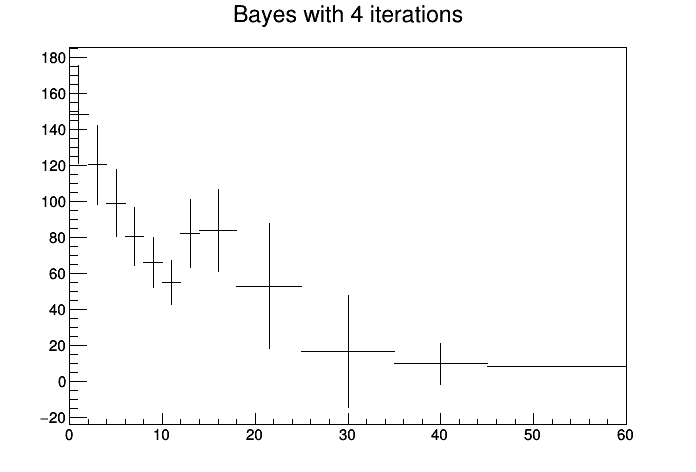

In [7]:
c1 = ROOT.TCanvas()
unfolded_hist = make_hist(unfolded_vec, truth, "Bayes with 4 iterations", errors_vec)
unfolded_hist.Draw()
c1.Draw()

 For a full list of options that can be passed to `RooFitUnfold` for the Error calculation please consult [the user guide](https://gitlab.cern.ch/RooUnfold/documentation/-/raw/master/RooUnfold_user_guide.pdf).

### Bias

Using the same prescription as for the variance the bias is calculated as:

$$
b_i = \frac{1}{K}\sum_{k}^{K} (\hat{\mu}_i)_k - \mu_i
$$

with the one practical difference that this calculation requires the truth vector:

In [8]:
unfold.CalculateBias(10000, spec.makeHistogram(truth))
bias_vec = unfold.Vbias()

In [9]:
bias_err = unfold.Ebias()

and visualise (with a slightly fancier plot)

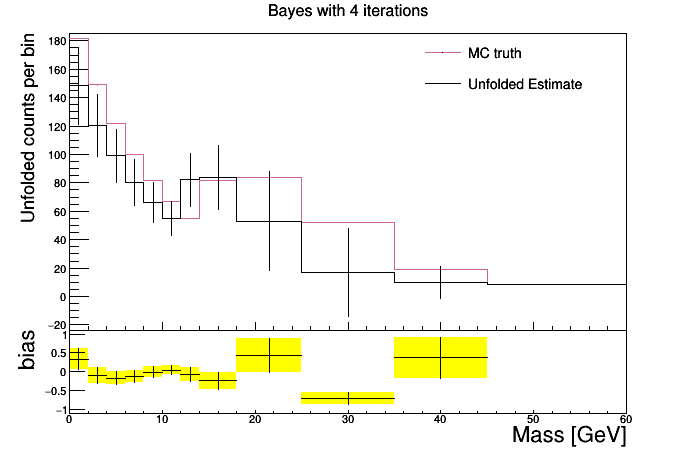

In [10]:
bias_hist = make_hist(bias_vec, truth, errors=bias_err)

c2 = ROOT.TCanvas()
pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0)
pad1.Draw()
c2.cd()
pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
pad2.SetTopMargin(0)
pad2.SetBottomMargin(0.3)
pad2.Draw()

pad1.cd()
unfolded_hist.GetYaxis().SetTitleOffset(.6)
unfolded_hist.GetYaxis().SetTitleSize(0.06)
unfolded_hist.GetYaxis().SetTitle("Unfolded counts per bin")
unfolded_hist.GetXaxis().SetLabelSize(0.0)
unfolded_hist.Draw()
truth.SetStats(0)
truth.SetLineColor(ROOT.kPink+2)
truth.Draw("Hsame")
unfolded_hist.Draw("Hsame")
l = ROOT.TLegend(.6,.7,.89,.89)
l.SetBorderSize(0)
l.AddEntry(truth, "MC truth")
l.AddEntry(unfolded_hist, "Unfolded Estimate")
l.Draw()

pad2.cd()

y_axis = bias_hist.GetYaxis()
y_axis.SetLabelSize(.1)
y_axis.SetRangeUser(-1.1,1.1)
y_axis.SetTitle("bias")
y_axis.SetTitleSize(.2)
y_axis.SetTitleOffset(.2)
y_axis.SetNdivisions(7)
x_axis = bias_hist.GetXaxis()
x_axis.SetLabelSize(.1)
x_axis.SetTitle("Mass [GeV]")
x_axis.SetTitleOffset(.6)
x_axis.SetTitleSize(.2)
bias_hist.SetFillColor(5)
bias_hist.Draw("E2")
bias_hist.Draw("Psame")
c2.Draw()

it should be noted here that given the way the bias is defined various iterations of the Richardson-Lucy algorithm implemented in `Bayes` will give almost no bias when comparing to the nominal truth that was produced with the same model as the data. In all cases (but particularly with some algorithms) it is very prudent to check the bias against an alternative (but suitable) model such as those under some theoretical variation. 

In [11]:
truth_alt = inputFile.Get("truthNP5down")
data_alt = inputFile.Get("recoNP5down")
alt_spec = ROOT.RooUnfoldSpec("unfold","unfold",
                          truth,"obs_truth",
                          reco,"obs_reco",
                          resp,
                          0,
                          data_alt,
                          False,0.0005)
alt_unfold_func = alt_spec.makeFunc(ROOT.RooUnfolding.kBayes,4)
alt_unfold = alt_unfold_func.unfolding()
alt_unfold.CalculateBias(10000, alt_spec.makeHistogram(truth_alt))
bias_alt = alt_unfold.Vbias()
bias_err_alt = alt_unfold.Ebias()

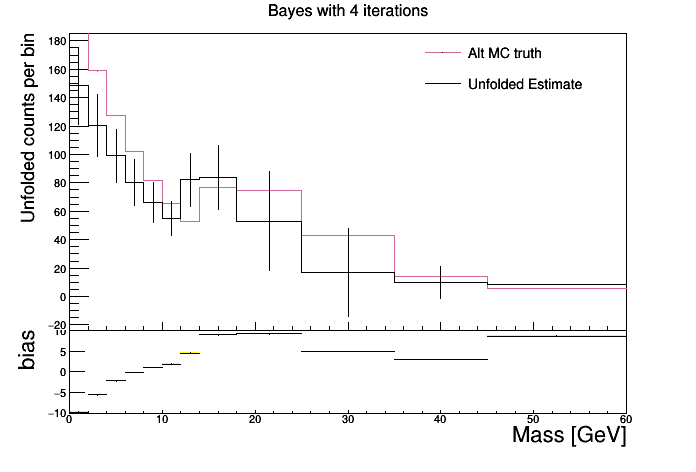

In [12]:
bias_hist_alt = make_hist(bias_alt, truth, errors=bias_err_alt)

c2 = ROOT.TCanvas()
pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0)
pad1.Draw()
c2.cd()
pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
pad2.SetTopMargin(0)
pad2.SetBottomMargin(0.3)
pad2.Draw()

pad1.cd()
unfolded_hist.GetYaxis().SetTitleOffset(.6)
unfolded_hist.GetYaxis().SetTitleSize(0.06)
unfolded_hist.GetYaxis().SetTitle("Unfolded counts per bin")
unfolded_hist.GetXaxis().SetLabelSize(0.0)
unfolded_hist.Draw()
truth_alt.SetStats(0)
truth_alt.SetLineColor(ROOT.kPink+2)
truth_alt.Draw("Hsame")
unfolded_hist.Draw("Hsame")
l = ROOT.TLegend(.6,.7,.89,.89)
l.SetBorderSize(0)
l.AddEntry(truth_alt, "Alt MC truth")
l.AddEntry(unfolded_hist, "Unfolded Estimate")
l.Draw()

pad2.cd()

y_axis = bias_hist_alt.GetYaxis()
y_axis.SetLabelSize(.1)
y_axis.SetRangeUser(-10.1,10.1)
y_axis.SetTitle("bias")
y_axis.SetTitleSize(.2)
y_axis.SetTitleOffset(.2)
y_axis.SetNdivisions(7)
x_axis = bias_hist_alt.GetXaxis()
x_axis.SetLabelSize(.1)
x_axis.SetTitle("Mass [GeV]")
x_axis.SetTitleOffset(.6)
x_axis.SetTitleSize(.2)
bias_hist_alt.SetFillColor(5)
bias_hist_alt.Draw("E2")
bias_hist_alt.Draw("Psame")
c2.Draw()

***note*** the bias has increased by an order 10 despite the two truth samples looking very similar.  

### Coverage Probability

The conditional probability defined above can be calculated in closed form under the assumption that the $\hat{\mu}_i$ are Gaussian distributed, the coverage probability is calculated using the $\sigma_{\mu_i}$ and $b_i$ from before:

$$
P_\mathrm{cov} = \Phi \left(\frac{b_i}{\sigma_\hat{\mu_i}}+1\right) -\Phi \left(\frac{b_i}{\sigma_\hat{\mu_i}}-1\right)
$$

where $\Phi$ is the standard Gaussian cumulative distribution function. 

This is calculated using the stored values in our `RooUnfoldSpec` from earlier:

In [23]:
coverage_vec = alt_unfold.CoverageProbV()

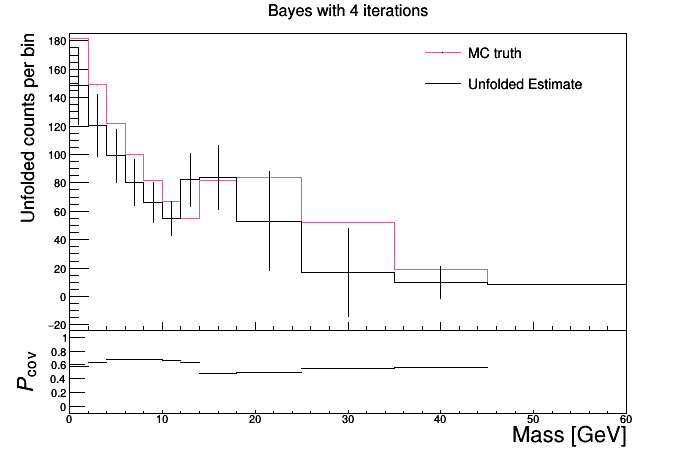

In [24]:
cov_hist = make_hist(coverage_vec, truth)

c3 = ROOT.TCanvas()
pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0)
pad1.Draw()
c3.cd()
pad2 = ROOT.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
pad2.SetTopMargin(0)
pad2.SetBottomMargin(0.3)
pad2.Draw()

pad1.cd()
unfolded_hist.GetYaxis().SetTitleOffset(.6)
unfolded_hist.GetYaxis().SetTitleSize(0.06)
unfolded_hist.GetYaxis().SetTitle("Unfolded counts per bin")
unfolded_hist.GetXaxis().SetLabelSize(0.0)
unfolded_hist.Draw()
truth.SetStats(0)
truth.SetLineColor(ROOT.kPink+2)
truth.Draw("Hsame")
unfolded_hist.Draw("Hsame")
l = ROOT.TLegend(.6,.7,.89,.89)
l.SetBorderSize(0)
l.AddEntry(truth, "MC truth")
l.AddEntry(unfolded_hist, "Unfolded Estimate")
l.Draw()

pad2.cd()

y_axis = cov_hist.GetYaxis()
y_axis.SetLabelSize(.1)
y_axis.SetRangeUser(-0.1,1.1)
y_axis.SetTitle(r"\$P_\mathrm{cov}\$")
y_axis.SetTitleSize(.2)
y_axis.SetTitleOffset(.2)
y_axis.SetNdivisions(7)
x_axis = cov_hist.GetXaxis()
x_axis.SetLabelSize(.1)
x_axis.SetTitle("Mass [GeV]")
x_axis.SetTitleOffset(.6)
x_axis.SetTitleSize(.2)

cov_hist.Draw("")

c3.Draw()

Remembering that $P_\mathrm{cov}$ tends towards the nominal coverage for a confidence interval of plus-or-minus one standard deviation about the maximum-likelihood estimator; $P_\mathrm{nom} = 68.3\%$. As such we expect that the estimate of $P_\mathrm{cov}$ should tend towards a value of 68.3%. 

As such we can define an estimator to have coverage if $P_\mathrm{cov}$ falls within some threshold $\epsilon$ of $P_\mathrm{nom} = 68.3\%$ such as $\epsilon\approx0.01$.

In [27]:
[abs(coverage_vec[i]-0.683)<0.01 for i in range(coverage_vec.GetNrows())]

[False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False]

in this case though the coverage is pretty good, only 2 bins actually have coverage. 

## Choosing Regularisation Strength

As described above, we should aim in our analyses to select the an algorithm with a regularisation parameter (such as $\tau$ or the number of iterations) such that $P_\mathrm{cov} = P_\mathrm{nom} − \epsilon$ with the threshold $\epsilon = 0.01$.

### Proceedure
To pick a parameter we need to loop over possible regularisation strengths, calculate the MSE and the coverage, in order to find the regularisaion strength that minimises the MSE whilst also having coverage on average. So lets make some helper functions! luckily we have all the components:

In [39]:
def get_comparision(spec, mu, alg, regs):
    MSE = []
    Covs = []
    Biases = []
    Variances = []
    for regularisation in regs:
        unfold_func = spec.makeFunc(alg, regularisation)
        unfold = unfold_func.unfolding()
        unfold.IncludeSystematics(ROOT.RooUnfolding.kAll)
        unfolded_vec = unfold.Vunfold()
        
        # calculate the variance
        unfold.SetNToys(1000)
        errors_vec = unfold.EunfoldV(ROOT.RooUnfolding.kErrors)
        
        # calculate the bias
        unfold.CalculateBias(1000, spec.makeHistogram(mu))
        bias_vec = unfold.Vbias()
        
        # calculate the coverage probability
        coverage_vec = unfold.CoverageProbV()
        
        # average and return
        errors_np = np.array([errors_vec[i] for i in range(errors_vec.GetNrows())])
        biases_np = np.array([bias_vec[i] for i in range(bias_vec.GetNrows())])
        coverage_np = np.array([coverage_vec[i] for i in range(coverage_vec.GetNrows())])
        
        MSE.append((errors_np+np.power(biases_np,2)).mean())
        Biases.append(np.power(biases_np,2).mean())
        Variances.append(errors_np.mean())
        Covs.append(coverage_np.mean())
    return (MSE, Covs, Biases, Variances)

Now we retrieve those lists. Here we take two options, the default spec (nominal data, and truth, including backgrounds), and the alt spec (a varied truth sample and the corresponding reco used as 'data')

In [41]:
svd_mse, svd_cov, b, v = get_comparision(spec, truth, ROOT.RooUnfolding.kSVD, list(range(2,12)))
alt_svd_mse, alt_svd_cov, ba, va = get_comparision(alt_spec, truth_alt, ROOT.RooUnfolding.kSVD, list(range(2,12)))

and convert these to graphs for plotting.

In [45]:
graph_svd_mse = ROOT.TGraph(len(svd_mse),np.arange(2,12,dtype='d'),np.array(svd_mse,dtype='d'))
graph_svd_cov = ROOT.TGraph(len(svd_cov),np.arange(2,12,dtype='d'),np.array(svd_cov,dtype='d'))
graph_b = ROOT.TGraph(len(svd_mse),np.arange(2,12,dtype='d'),np.array(b,dtype='d'))
graph_v = ROOT.TGraph(len(svd_cov),np.arange(2,12,dtype='d'),np.array(v,dtype='d'))
graph_svd_mse_alt = ROOT.TGraph(len(alt_svd_mse),np.arange(2,12,dtype='d'),np.array(alt_svd_mse,dtype='d'))
graph_svd_cov_alt = ROOT.TGraph(len(alt_svd_cov),np.arange(2,12,dtype='d'),np.array(alt_svd_cov,dtype='d'))

And plot!

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


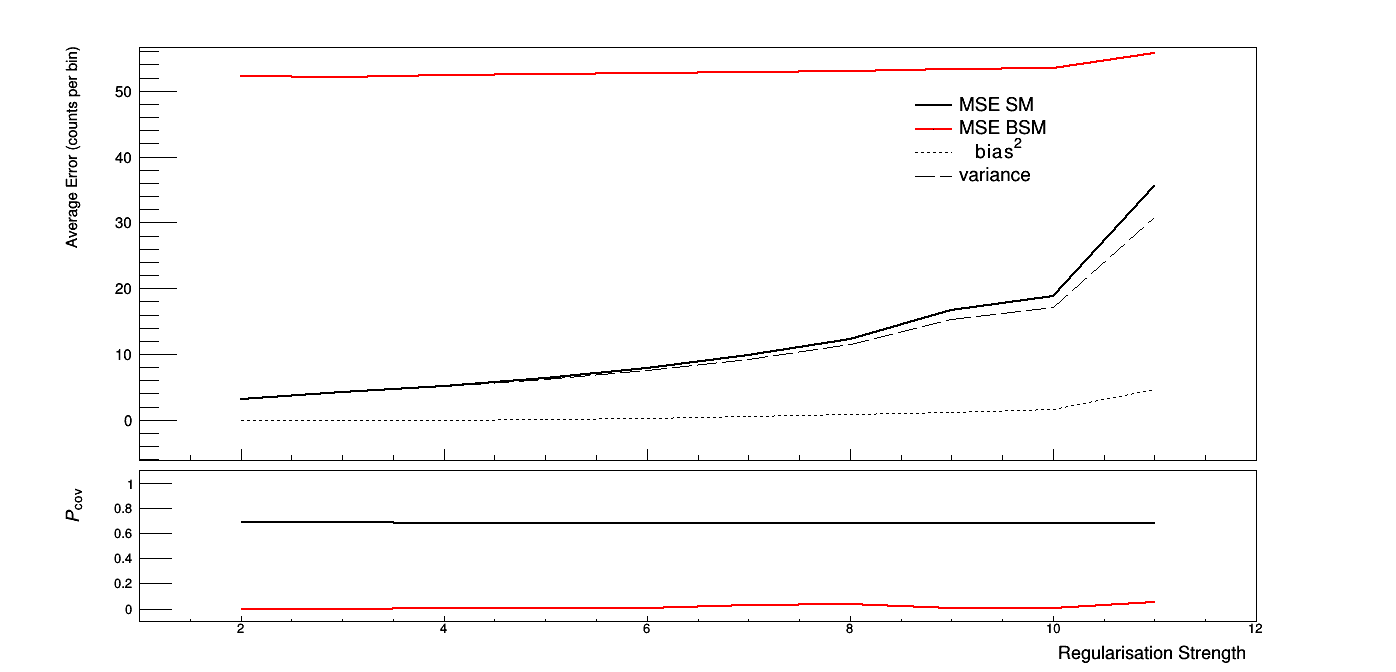

In [75]:
c = ROOT.TCanvas("c","c", 1400, 700)
# first set up the two pads
pad1 = ROOT.TPad("p1","p",0,.3,1,1, 0)
pad1.SetBottomMargin(0.02)
pad1.Draw()
c.cd()
pad2 = ROOT.TPad("p2","p",0,0,1,.3, 0)
pad2.SetTopMargin(0.)
pad2.SetBottomMargin(0.25)
pad2.Draw()
pad1.cd()
# first top pad (MSE)
# get range
upper = max(np.array(svd_mse).max() + np.array(svd_mse).std(),
            np.array(alt_svd_mse).max() + np.array(alt_svd_mse).std())
lower = min(np.array(svd_mse).min() - np.array(svd_mse).std(),
            np.array(alt_svd_mse).min() - np.array(alt_svd_mse).std())

# explicitly draw the frame (easier for graphs)
frame1 = pad1.DrawFrame(1, lower,12,upper)
frame1.GetXaxis().SetLabelSize(0.)
frame1.GetYaxis().SetTitle("Average Error (counts per bin)")
# and draw them
graph_svd_mse.SetLineWidth(2)
graph_svd_mse.Draw()
graph_svd_mse_alt.SetLineWidth(2)
graph_svd_mse_alt.SetLineColor(2)
graph_svd_mse_alt.Draw()
graph_b.SetLineStyle(2)
graph_b.Draw()
graph_v.SetLineStyle(9)
graph_v.Draw()

# add a legend
l = ROOT.TLegend(0.65,0.6,0.8,0.8)
l.SetBorderSize(0)
l.AddEntry(graph_svd_mse,"MSE SM")
l.AddEntry(graph_svd_mse_alt,"MSE BSM")
l.AddEntry(graph_b,r"\$\mathrm{bias}^2\$ ")
l.AddEntry(graph_v,"variance")
l.Draw()

# lower pad (average coverage probability)
pad2.cd()
frame2 = pad2.DrawFrame(1, -0.1,12,1.1)
frame2.GetYaxis().SetNdivisions(7)
frame2.GetYaxis().SetLabelSize(.07)
frame2.GetYaxis().SetTitle(r"\$P_\mathrm{cov}\$")
frame2.GetYaxis().SetTitleSize(.1)
frame2.GetYaxis().SetTitleOffset(.3)
frame2.GetXaxis().SetLabelSize(.07)
frame2.GetXaxis().SetTitle("Regularisation Strength")
frame2.GetXaxis().SetTitleSize(.1)
graph_svd_cov.SetLineWidth(2)
graph_svd_cov.Draw()
graph_svd_cov_alt.SetLineWidth(2)
graph_svd_cov_alt.SetLineColor(2)
graph_svd_cov_alt.Draw()
c.Draw()

Now ordinarily we could look for the crossing point in $b^2$ and $V[\hat{\mu}]$ or look for the value with the lowest MSE that still has coverage...

# Notes for debugging! Carsten and Lydia!

Ok so a couple of points here. 

## 1. Truth and Data used in Bias calculation
I want to make sure how we recommend to use this bias calculation. What I've shown here is using different data with truth corresponding to that alternative data? Unregularised is unbiased and would tend toward the alt truth. But Pim in his tutorial uses the same RooUnfoldSpec (nominal data) with a different truth. And when I accidentally used the alternative Spec (so BSM data) together with the nominal truth, it gave an almost unbiassed solution. Does the Bias calculation take into account the data? Or just sample from an asimov created from the response? I'm confused!

## 2. Why does my Bias alway increase with reducing regularisation?
I've tried both Bayes and SVD the stronger the regularisation the lower the variance and the bias. I've tried upping the number of toys to make sure it's not going crazy.

## 3. Which of these values should be relative?
If I remember correctly we used the absolute squared bias and the relative variance in the paper. This gave the nice crossing point but since the units on both are the same I found that hard to justify. Pim shows relative wherever possible but for already tiny biases (see points 1 and 2) this gets really tiny. 